# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'2.9.0+cpu'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and **only 10% of the images** (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:  # wb: write binary
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


 ## 2. Becoming one with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/test/sushi/2276986.jpg
Image class: sushi
Image height: 512
Image width: 512


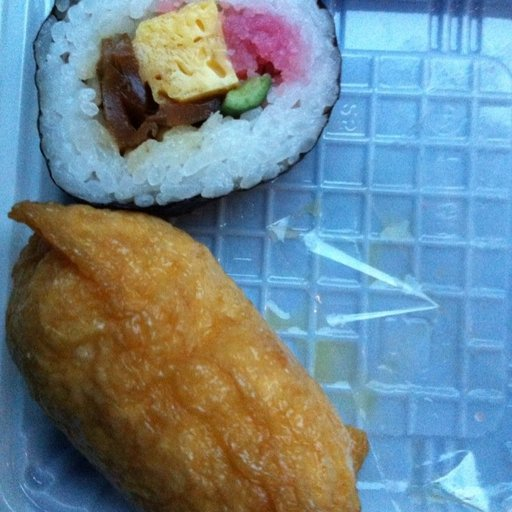

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

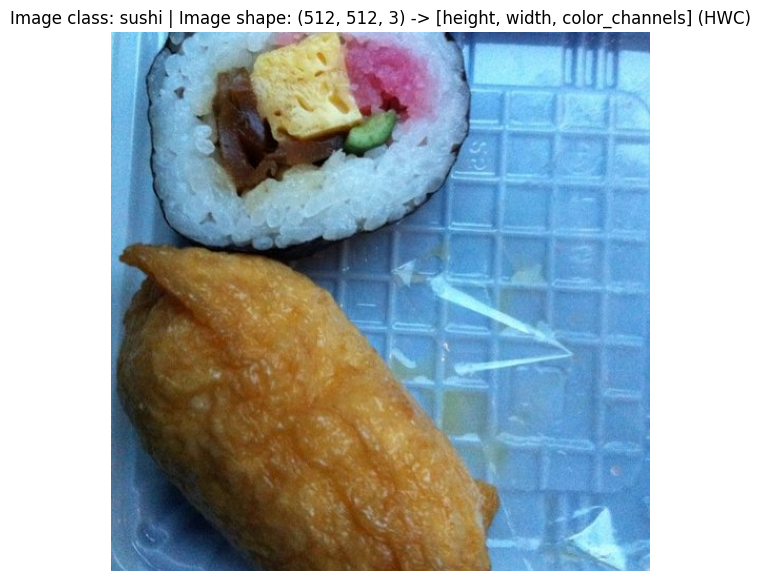

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

array([[[149, 229, 254],
        [145, 225, 250],
        [129, 206, 236],
        ...,
        [ 60,  95, 153],
        [ 67,  99, 160],
        [ 65,  97, 158]],

       [[154, 231, 255],
        [148, 225, 251],
        [138, 215, 245],
        ...,
        [ 63,  98, 156],
        [ 69, 101, 162],
        [ 66,  98, 159]],

       [[152, 228, 254],
        [144, 220, 246],
        [142, 217, 248],
        ...,
        [ 64,  96, 155],
        [ 67,  99, 158],
        [ 62,  94, 153]],

       ...,

       [[ 66, 119, 153],
        [ 75, 128, 162],
        [ 77, 129, 166],
        ...,
        [138, 191, 235],
        [137, 190, 234],
        [157, 210, 254]],

       [[ 74, 124, 159],
        [ 80, 130, 165],
        [ 81, 131, 168],
        ...,
        [148, 199, 244],
        [157, 208, 253],
        [159, 210, 253]],

       [[ 82, 132, 167],
        [ 85, 135, 170],
        [ 85, 133, 171],
        ...,
        [149, 200, 245],
        [168, 217, 255],
        [150, 199, 242]]], dtype=uint8)
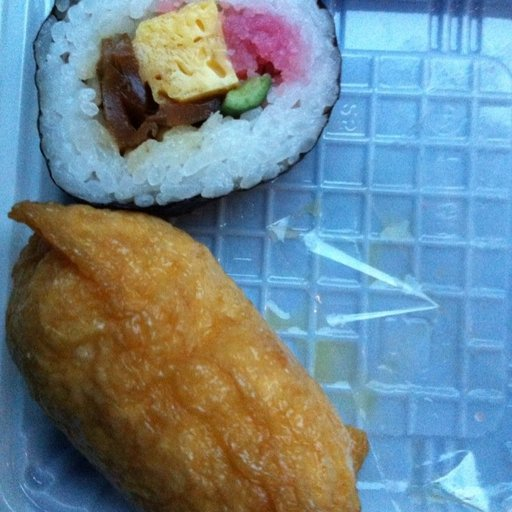

In [ ]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64, 64)), # 想使用先前的model_2 (是64*64)
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),   # 50%被水平反轉
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

### `transforms.Compose` 是什麼？

`transforms.Compose` 是一個類別，它允許你將一個列表中的所有 `transform` 物件串聯起來。當你將一個影像傳遞給這個 `Compose` 物件時，它會按照列表中定義的順序，依序將每個轉換應用到影像上，前一個轉換的輸出會作為下一個轉換的輸入。

**主要目的：**

1.  **簡化多個轉換的應用**：想像一下如果你有 5 個不同的轉換要應用到每張圖片上，如果手動一個一個地呼叫它們會讓程式碼變得冗長且容易出錯。`Compose` 讓你只用一行程式碼就能應用所有轉換。
2.  **建立可重複使用的轉換流程**：你可以定義一個 `Compose` 物件，然後在資料載入器（`DataLoader`）或其他地方重複使用它，確保所有影像都經過相同的處理流程。
3.  **提高程式碼可讀性**：將所有的轉換定義在一個地方，讓資料預處理的流程一目了然。

**工作原理：**

它接受一個 `transforms` 列表作為參數。當你呼叫 `Compose` 物件時，它會依序執行列表中的每個轉換。例如：

```python
data_transform = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor()
])

# 當你執行 data_transform(img) 時，實際發生的是：
# 1. 影像 img 傳入 transforms.Resize(size=(64, 64))，得到一個縮放後的影像。
# 2. 縮放後的影像傳入 transforms.RandomHorizontalFlip(p=0.5)，得到一個可能翻轉的影像。
# 3. 可能翻轉的影像傳入 transforms.ToTensor()，最終轉換為 PyTorch 張量。
```

所以，你之前看到的 `data_transform(img)` 就是在呼叫這個包含三個步驟的轉換序列，最終得到一個形狀為 `[3, 64, 64]` 的 PyTorch 張量。

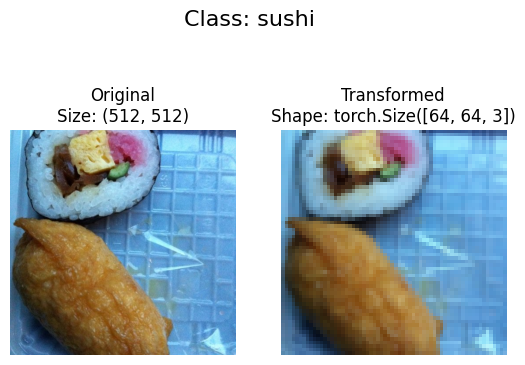

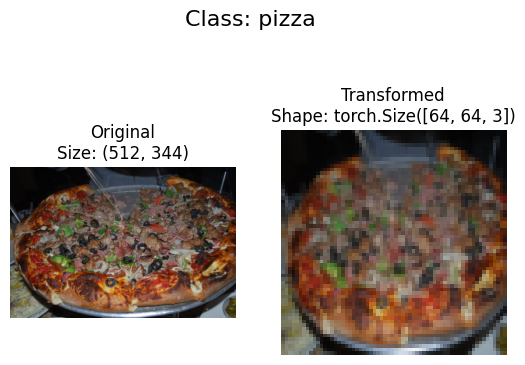

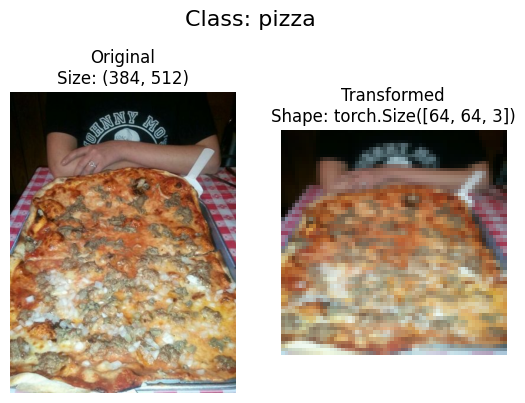

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)  # 隨機選擇 n 個不重複的元素（在這裡是圖片路徑）
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      # ax 代表的是 子圖物件（Axes）
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

當您將 root=train_dir 傳遞給 ImageFolder 時，它會掃描 train_dir（即 data/pizza_steak_sushi/train）下的所有子資料夾。
- 每個子資料夾的名稱（例如 'pizza', 'steak', 'sushi'）都會被視為一個類別（class label）。
- 所有位於該子資料夾內的圖片都會被自動分配對應的類別標籤。


In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

具體來說，`train_data.samples` 的格式是一個由元組（tuple）組成的列表，每個元組包含兩個元素：

1.  **`image_path`** (字串或 `pathlib.Path` 物件)：圖片的完整路徑。
2.  **`class_index`** (整數)：圖片所屬類別的整數索引，這個索引是 `ImageFolder` 根據資料夾名稱自動映射出來的 (例如 'pizza': 0, 'steak': 1, 'sushi': 2)。


例如，`train_data.samples[0]` 的輸出是 `('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)`，這表示：

*   `'data/pizza_steak_sushi/train/pizza/1008844.jpg'` 是第一張圖片的路徑。
*   `0` 是這張圖片的類別索引，對應到 `class_dict` 中的 'pizza'。

這個屬性非常有用，因為它提供了一個快速查看資料集中所有圖片及其標籤的方式，讓您能夠了解資料集的內部結構，也方便進行除錯或進一步的資料分析。

In [ ]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

.dtype 屬性通常用於查詢 torch.Tensor (PyTorch 張量) 和 numpy.ndarray (NumPy 陣列) 的資料類型。在您遇到的錯誤中，label 是一個普通的 Python 整數（int），所以它沒有 .dtype 這個屬性。

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

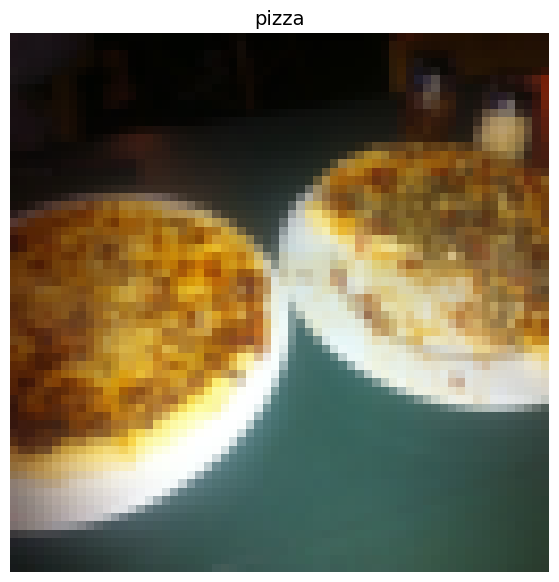

In [ ]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f828573c770>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8285771580>)

### `num_workers` 是什麼？

當你從硬碟讀取資料（例如圖片檔案），然後對它們進行預處理（例如調整大小、翻轉、轉換為張量），這些操作可能會花費一些時間。如果在訓練迴圈中每次需要資料時才執行這些操作，模型的 GPU（或 CPU）可能會因為等待資料準備好而閒置，這稱為**資料載入瓶頸**。

`num_workers` 的作用就是解決這個問題：

*   **多進程載入**：它允許 `DataLoader` 在背景使用多個子進程來預先載入和預處理資料。
*   **提高效率**：當主進程（通常是訓練模型的地方）正在處理一個批次的資料時，其他 `num_workers` 個子進程就可以同時在背景準備下一個或下幾個批次的資料。
*   **減少閒置時間**：這樣可以大大減少模型等待資料的時間，讓 GPU 更充分地利用起來，從而加速模型的訓練。

**如何選擇 `num_workers` 的值？**

*   `num_workers=0` (預設值)：表示所有資料載入和預處理都在主進程中進行。這通常用於除錯，或者當您的資料集非常小，載入時間可以忽略不計時。
*   `num_workers > 0`：建議使用這個選項以利用多核 CPU。一個常見的起點是設定為您電腦的 CPU 核心數（或者 `os.cpu_count()` 的返回值），或者 `os.cpu_count() // 2`。

**注意事項：**

*   `num_workers` 設定過高不一定會更好，因為過多的進程可能會導致 CPU 負載過重、記憶體消耗過大，甚至可能因為進程間通訊的開銷而降低效率。
*   在 Windows 系統上，如果您在 Colab 或某些開發環境中運行 PyTorch，並且 `num_workers > 0`，您可能會遇到問題（通常是 `RuntimeError`）。這是因為 Windows 對於多進程的處理方式與 Linux/macOS 不同。一個常見的解決方法是將相關的程式碼放在 `if __name__ == '__main__':` 區塊中，或者在 Windows 上將 `num_workers` 設定為 0。

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset


In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
# os.scandir() 是一個比 os.listdir() 更有效率的函數，
# 它會回傳一個迭代器（iterator），其中包含 DirEntry 物件。
# 每個 DirEntry 物件代表了 target_directory 中的一個文件或子目錄

class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [ ]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

當您獲得 `PIL.Image.Image` 物件後，您可以存取以下常用資訊和方法：

*   **圖片尺寸**：`img.size` (回傳一個元組 `(width, height)`)。
*   **圖片寬度**：`img.width`。
*   **圖片高度**：`img.height`。
*   **圖片模式**：`img.mode` (例如 'RGB' 代表彩色圖，'L' 代表灰度圖)。
*   **圖片格式**：`img.format` (例如 'JPEG', 'PNG')。
*   **圖片資訊**：`img.info` (一個字典，包含元數據，如 DPI、EXIF 等，取決於圖片檔案)。

您也可以對這個 `Image` 物件執行多種操作，例如：

*   **調整大小**：`img.resize((new_width, new_height))`。
*   **裁剪**：`img.crop((left, upper, right, lower))`。
*   **轉換模式**：`img.convert('L')` (轉換為灰度圖)。
*   **轉換為 NumPy 陣列**：`np.array(img)`。
*   **轉換為 PyTorch 張量**：通常透過 `torchvision.transforms.ToTensor()(img)`。

所以，`Image.open(image_path)` 不僅僅是「得到資訊」，它更是提供了一個對圖片進行全面處理的入口。

### `__getitem__` 是什麼？

當您為一個類別定義了 `__getitem__(self, index)` 方法後，這個類別的物件就可以使用像列表或字典一樣的索引（`[]`）來存取其內部的元素。換句話說，它讓您的物件變得「可索引」（subscriptable）。

**在 PyTorch 的 `Dataset` 類中，`__getitem__` 的作用是：**

1.  **根據索引獲取單個樣本**：當您呼叫 `dataset[idx]` 時，實際上就是 PyTorch 內部在呼叫 `dataset.__getitem__(idx)`。
2.  **回傳資料和標籤**：`__getitem__` 方法的職責是載入並回傳資料集中指定索引 `idx` 的單個樣本。對於圖像分類任務，這通常是一個 `(image, label)` 對。
3.  **應用轉換**：在回傳樣本之前，通常會在 `__getitem__` 內部將預先定義好的轉換（`transform`）應用到資料上。

**以您的 `ImageFolderCustom` 類別為例：**

```python
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index) # 載入圖片 (PIL Image 物件)
    class_name = self.paths[index].parent.name # 從圖片路徑獲取類別名稱
    class_idx = self.class_to_idx[class_name] # 將類別名稱映射為整數索引

    # 應用轉換（如果有定義的話）
    if self.transform:
      return self.transform(img), class_idx # 回傳經過轉換的張量和整數標籤
    else:
      return img, class_idx # 回傳未經轉換的 PIL Image 和整數標籤
```

**總結來說：**

`__getitem__` 方法是 `Dataset` 類和 `DataLoader` 協同工作的關鍵。`DataLoader` 會不斷地呼叫 `Dataset` 的 `__getitem__` 方法來獲取批次（batch）的資料，然後將這些資料餵給模型進行訓練或推論。它確保了每次模型需要資料時，都能夠正確地載入、預處理並回傳單個樣本。

In [ ]:
train_data[0] # __getitem__

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [ ]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f828563e6c0>,
 <__main__.ImageFolderCustom at 0x7f8285a605c0>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
len(test_data), len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [ ]:
train_data_custom[0]

(tensor([[[0.3922, 0.3922, 0.4000,  ..., 0.3843, 0.3843, 0.3725],
          [0.4078, 0.4000, 0.4078,  ..., 0.3882, 0.4000, 0.3961],
          [0.4039, 0.4078, 0.4078,  ..., 0.4039, 0.4118, 0.4078],
          ...,
          [0.5451, 0.3922, 0.5961,  ..., 0.5255, 0.4706, 0.4118],
          [0.5412, 0.3569, 0.5333,  ..., 0.5294, 0.5333, 0.5294],
          [0.5843, 0.4431, 0.2784,  ..., 0.5216, 0.5294, 0.5294]],
 
         [[0.2431, 0.2275, 0.2275,  ..., 0.2353, 0.2431, 0.2392],
          [0.2431, 0.2314, 0.2353,  ..., 0.2549, 0.2627, 0.2627],
          [0.2275, 0.2353, 0.2471,  ..., 0.2745, 0.2667, 0.2627],
          ...,
          [0.5176, 0.3529, 0.5647,  ..., 0.4863, 0.4275, 0.3725],
          [0.5098, 0.3176, 0.4980,  ..., 0.4902, 0.4902, 0.4902],
          [0.5490, 0.4118, 0.2353,  ..., 0.4824, 0.4863, 0.4784]],
 
         [[0.1137, 0.1294, 0.1294,  ..., 0.1804, 0.1882, 0.1725],
          [0.1255, 0.1333, 0.1176,  ..., 0.1922, 0.1922, 0.2039],
          [0.1098, 0.1373, 0.1373,  ...,

### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [ ]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)  # 1行、n列、第i+1個(從1開始算的)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

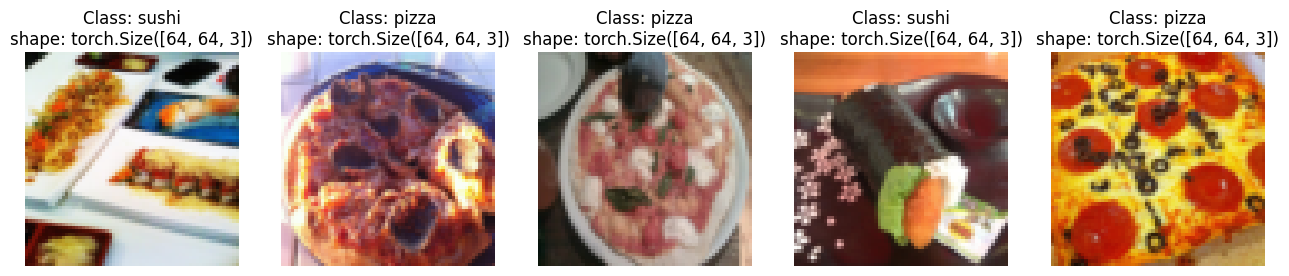

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f8285562600>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8284edcbc0>)

In [ ]:
# Get image and label from custom datloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

In [ ]:
# Let's look at trivailaugment - https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
])

### `TrivialAugmentWide` 是什麼？

`TrivialAugmentWide` 是 `torchvision.transforms` 模組中一個強大的資料增強（Data Augmentation）策略，它旨在幫助模型在訓練時看到更多樣化的資料，從而提高模型的泛化能力。

**核心思想：**

`TrivialAugmentWide` 的設計靈感來自於 `AutoAugment` 和 `RandAugment` 等自動化資料增強方法。這些方法的核心是從一個預定義的轉換操作池中，隨機選擇並應用一系列的圖像轉換。與手動微調增強策略相比，自動化方法通常能找到更有效的增強組合，並且減少了人工參與的需要。

**主要特點：**

1.  **操作池 (Operation Pool)**：`TrivialAugmentWide` 包含一個豐富的圖像轉換操作池，例如：
    *   `ShearX`, `ShearY` (剪切)
    *   `TranslateX`, `TranslateY` (平移)
    *   `Rotate` (旋轉)
    *   `Brightness`, `Color`, `Contrast`, `Sharpness` (色彩和銳利度調整)
    *   `Posterize`, `Solarize`, `AutoContrast`, `Equalize` (圖像像素操作)
    *   `RandomErasing` (隨機擦除)
    *   以及 `Identity` (不做任何改變) 等。

2.  **隨機選擇**：對於每一張輸入圖片，它會隨機選擇 **一個** 圖像轉換操作。例如，它可能會選擇 `Rotate`，也可能選擇 `Brightness`。

3.  **隨機強度 (Magnitude)**：當選定一個操作後，它會從該操作預定義的強度範圍中，隨機選擇一個增強強度來應用這個操作。這個強度是連續的，並且通常由 `num_magnitude_bins` 參數控制，該參數決定了強度範圍被劃分成多少個離散的 "bin"。

4.  **無學習參數**：與 `AutoAugment` 不同，`TrivialAugmentWide` 不需要額外的模型來學習增強策略，這使得它更容易使用和實現。

**`num_magnitude_bins` 參數：**

您在程式碼中看到的 `num_magnitude_bins=31` 表示每個增強操作的強度範圍會被切分為 31 個離散的等級。例如，如果 `Rotate` 操作的強度範圍是 `-30` 度到 `+30` 度，那麼這 31 個等級會均勻分佈在這個範圍內，`TrivialAugmentWide` 會從這 31 個等級中隨機挑選一個強度值來旋轉圖片。

**為什麼使用 `TrivialAugmentWide`？**

*   **提高泛化能力**：通過引入多樣化的圖像變換，模型能夠學會識別不同視角、光照、顏色變化的物體，使其在面對未見過的真實世界數據時表現更好。
*   **減少過擬合**：資料增強有效地擴大了訓練集，降低了模型記住訓練數據特定細節而無法推廣到新數據的風險。
*   **易於使用**：作為一個 `transforms.Compose` 的組件，它非常容易集成到現有的 PyTorch 資料處理流程中。

總之，`TrivialAugmentWide` 是一種高效且易於實施的資料增強策略，特別適合於視覺任務，能夠顯著提升模型的性能和魯棒性。

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/930553.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/971934.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg')]

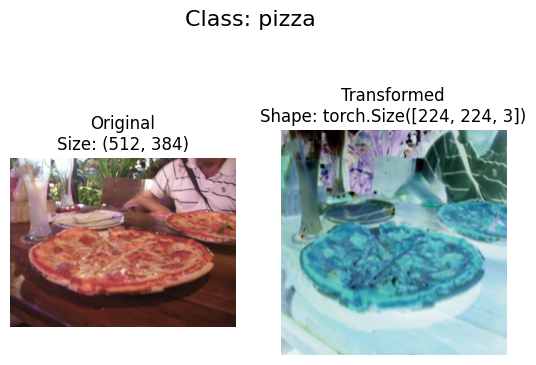

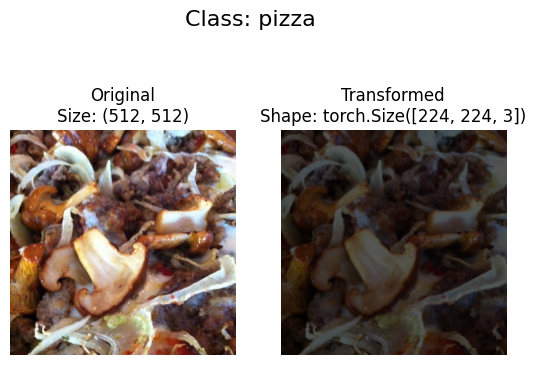

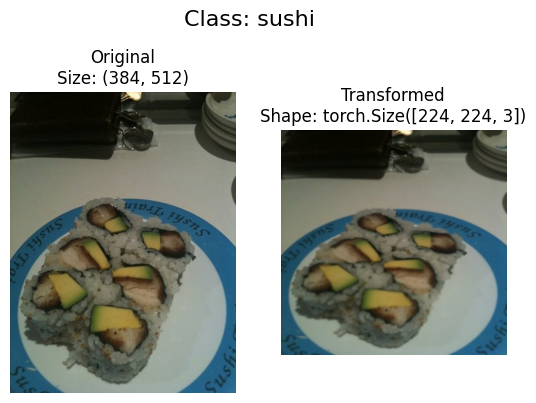

In [ ]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

### 僅應用旋轉變換 (`transforms.RandomRotation`)

如果您只想對圖片進行旋轉，可以使用 `torchvision.transforms.RandomRotation`。這個轉換會隨機選擇一個角度來旋轉圖片。您可以控制旋轉角度的範圍和一些其他參數。

**主要參數：**

*   **`degrees` (int 或 sequence)**：
    *   如果是一個整數，例如 `degrees=30`，則旋轉角度會從 `-30` 到 `+30` 度之間隨機選擇。
    *   如果是一個序列，例如 `degrees=(-10, 10)`，則旋轉角度會從 `-10` 到 `+10` 度之間隨機選擇。
*   **`interpolation` (InterpolationMode)**：圖像插值方法。預設為 `InterpolationMode.NEAREST`。常用的有 `InterpolationMode.BILINEAR` (雙線性插值) 或 `InterpolationMode.BICUBIC` (雙三次插值)，通常用於高質量圖像縮放和旋轉。您需要 `from torchvision.transforms.functional import InterpolationMode` 來使用它。
*   **`expand` (bool)**：如果為 `True`，則輸出圖片會被擴大以容納整個旋轉後的圖片，並使所有像素可見。如果為 `False`（預設），則輸出圖片的尺寸與輸入圖片相同，旋轉後的圖片超出邊界的部分會被裁剪。
*   **`center` (tuple, optional)**：旋轉的中心點。預設為圖片的中心。
*   **`fill` (sequence 或 int)**：在圖片旋轉後，超出邊界或新增加的區域（如果 `expand=True`）會用這個值填充。如果圖片是 RGB 模式，可以傳入一個 `(R, G, B)` 元組；如果是灰度圖，傳入一個整數。

**範例：**

### 固定角度旋轉 (例如 90 度、180 度)

如果您想讓圖片以固定的 90、180 或 270 度進行旋轉，可以使用 `torchvision.transforms.RandomChoice` 結合 `torchvision.transforms.functional.rotate` 來隨機選擇其中一種旋轉。這樣可以確保每次旋轉都是這些特定角度中的一個，而不是一個範圍內的任意角度。

**範例：**

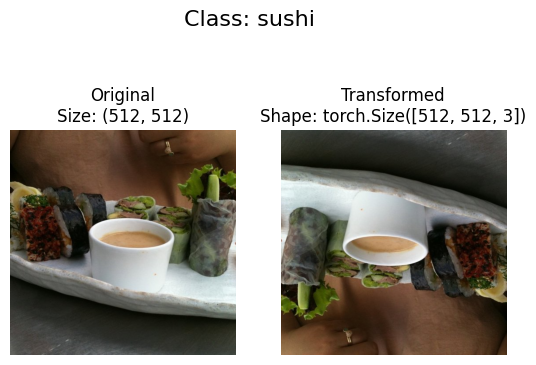

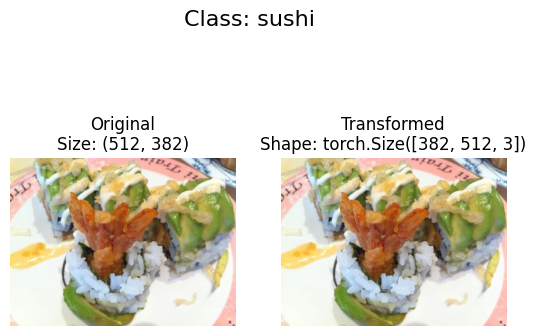

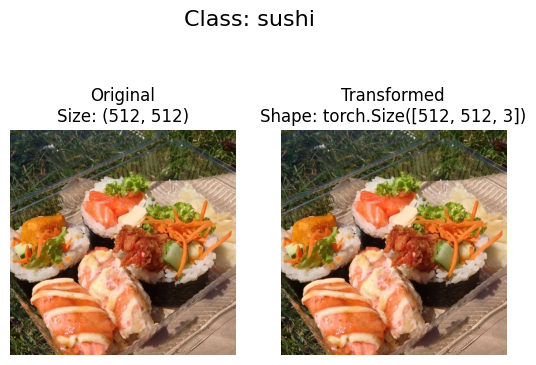

In [ ]:
from torchvision import transforms
from torchvision.transforms import functional as TF

# 旋轉 0, 90, 180, 270 度（隨機選擇其中一個）
fixed_rotation_transform = transforms.Compose([
    # transforms.Resize(size=(64, 64)), # 先將圖片縮放至統一大小
    transforms.RandomChoice([
        transforms.Lambda(lambda x: TF.rotate(x, 0)),
        transforms.Lambda(lambda x: TF.rotate(x, 90)),
        transforms.Lambda(lambda x: TF.rotate(x, 180)),
        transforms.Lambda(lambda x: TF.rotate(x, 270))
    ]),
    transforms.ToTensor()
])

# 繪製隨機固定角度旋轉後的圖片
plot_transformed_images(
    image_paths=image_path_list,
    transform=fixed_rotation_transform,
    n=3,
    seed=None
)

### 水平翻轉 (`transforms.RandomHorizontalFlip`)

`transforms.RandomHorizontalFlip` 會以給定的機率 `p` 對圖片進行水平翻轉。預設 `p=0.5`，表示有 50% 的機率會水平翻轉。

**範例：**

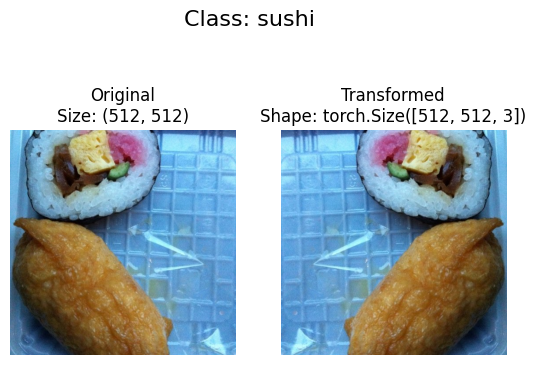

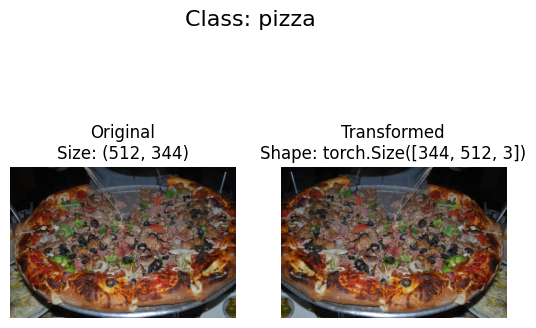

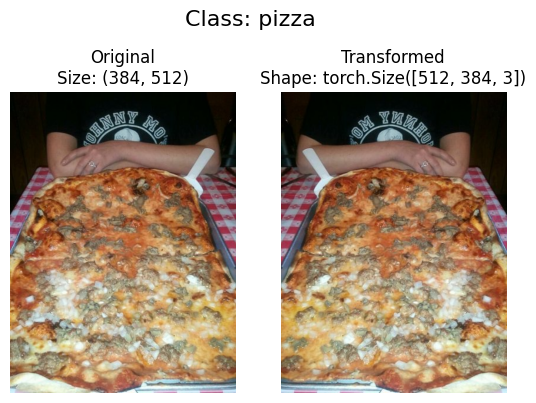

In [ ]:
horizontal_flip_transform = transforms.Compose([
    # transforms.Resize(size=(64, 64)), # 先將圖片縮放至統一大小
    transforms.RandomHorizontalFlip(p=0.8), # 80% 的機率水平翻轉
    transforms.ToTensor()
])

# 繪製隨機水平翻轉後的圖片
plot_transformed_images(
    image_paths=image_path_list,
    transform=horizontal_flip_transform,
    n=3,
    seed=42
)

### 垂直翻轉 (`transforms.RandomVerticalFlip`)

`transforms.RandomVerticalFlip` 會以給定的機率 `p` 對圖片進行垂直翻轉。預設 `p=0.5`，表示有 50% 的機率會垂直翻轉。

**範例：**

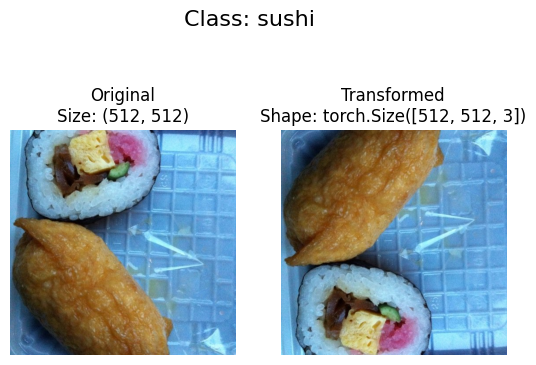

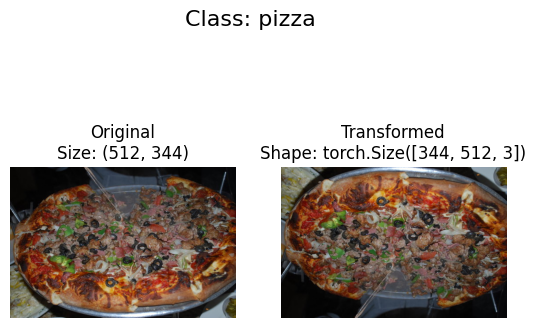

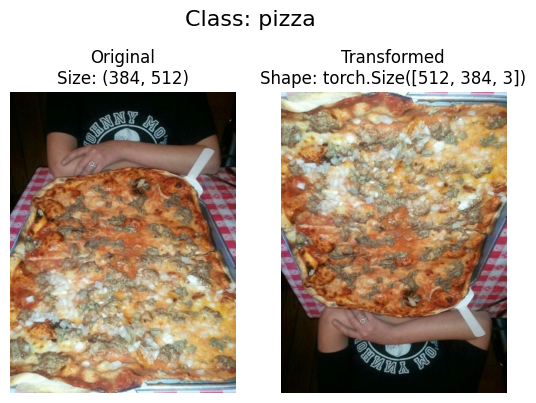

In [ ]:
vertical_flip_transform = transforms.Compose([
    # transforms.Resize(size=(64, 64)), # 先將圖片縮放至統一大小
    transforms.RandomVerticalFlip(p=0.8), # 80% 的機率垂直翻轉
    transforms.ToTensor()
])

# 繪製隨機垂直翻轉後的圖片
plot_transformed_images(
    image_paths=image_path_list,
    transform=vertical_flip_transform,
    n=3,
    seed=42
)

### 綜合應用

您可以將這些轉換組合在一個 `transforms.Compose` 中，讓每張圖片在經過資料載入時，都有機會應用到這些不同的增強策略。

**範例：**

In [ ]:
combined_transform = transforms.Compose([
    # transforms.Resize(size=(64, 64)),
    transforms.RandomChoice([
        transforms.Lambda(lambda x: TF.rotate(x, 0)),
        transforms.Lambda(lambda x: TF.rotate(x, 90)),
        transforms.Lambda(lambda x: TF.rotate(x, 180)),
        transforms.Lambda(lambda x: TF.rotate(x, 270))
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

# 繪製綜合轉換後的圖片
plot_transformed_images(
    image_paths=image_path_list,
    transform=combined_transform,
    n=10,
    seed=42
)

Output hidden; open in https://colab.research.google.com to view.

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
                                       transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int)-> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        # x = self.conv_block_1(x)
        # # print(x.shape)
        # x = self.conv_block_2(x)
        # # print(x.shape)
        # x = self.classifier(x)
        # # print(x.shape)
        # return x

        # 上面的寫法會from compute->memory-compute->memory
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html



### `TinyVGG` 模型中 `nn.Linear` 層的 `in_features` 計算解釋

在 `TinyVGG` 模型中，輸入圖片會經過一系列的卷積層（`nn.Conv2d`）和最大池化層（`nn.MaxPool2d`），然後才進入全連接層（`nn.Linear`）。`nn.Linear` 的 `in_features` 參數必須與前一個層輸出後的**扁平化**張量大小相匹配。讓我們追蹤圖片的形狀變化：

假設輸入圖片的尺寸是 `(3, 64, 64)`，其中 `3` 是顏色通道數，`64x64` 是高度和寬度。

1.  **`conv_block_1` 區塊的形狀變化：**
    *   **輸入到第一個 `nn.Conv2d`**：`[batch_size, input_shape, 64, 64]`
        *   `nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0)`
        *   計算輸出空間維度（高度或寬度）： `(輸入維度 - kernel_size + 2 * padding) / stride + 1`
        *   `(64 - 3 + 2*0) / 1 + 1 = 62`
        *   所以輸出形狀為：`[batch_size, hidden_units, 62, 62]`
    *   **輸入到第二個 `nn.Conv2d`**：`[batch_size, hidden_units, 62, 62]`
        *   `nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0)`
        *   輸出維度：`(62 - 3 + 2*0) / 1 + 1 = 60`
        *   所以輸出形狀為：`[batch_size, hidden_units, 60, 60]`
    *   **輸入到 `nn.MaxPool2d`**：`[batch_size, hidden_units, 60, 60]`
        *   `nn.MaxPool2d(kernel_size=2, stride=2)`
        *   輸出維度： `輸入維度 / kernel_size`
        *   `60 / 2 = 30`
        *   所以 `conv_block_1` 的最終輸出形狀為：`[batch_size, hidden_units, 30, 30]`

2.  **`conv_block_2` 區塊的形狀變化：**
    *   **輸入到第一個 `nn.Conv2d`**：`[batch_size, hidden_units, 30, 30]`
        *   `nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0)`
        *   輸出維度：`(30 - 3 + 2*0) / 1 + 1 = 28`
        *   所以輸出形狀為：`[batch_size, hidden_units, 28, 28]`
    *   **輸入到第二個 `nn.Conv2d`**：`[batch_size, hidden_units, 28, 28]`
        *   `nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0)`
        *   輸出維度：`(28 - 3 + 2*0) / 1 + 1 = 26`
        *   所以輸出形狀為：`[batch_size, hidden_units, 26, 26]`
    *   **輸入到 `nn.MaxPool2d`**：`[batch_size, hidden_units, 26, 26]`
        *   `nn.MaxPool2d(kernel_size=2, stride=2)`
        *   輸出維度：`26 / 2 = 13`
        *   所以 `conv_block_2` 的最終輸出形狀為：`[batch_size, hidden_units, 13, 13]`

3.  **`nn.Flatten()` 層：**
    *   在 `conv_block_2` 之後，輸出形狀是 `[batch_size, hidden_units, 13, 13]`。
    *   `nn.Flatten()` 會將 `batch_size` 維度之外的所有維度扁平化成一個單一的維度。
    *   因此，`nn.Flatten()` 的輸出形狀會變成 `[batch_size, hidden_units * 13 * 13]`。

4.  **`nn.Linear` 層：**
    *   `nn.Linear` 層的第一個參數 `in_features` 必須與前一層扁平化後的特徵數量完全一致。
    *   所以，`nn.Linear(in_features=hidden_units * 13 * 13, out_features=output_shape)` 正是將 `hidden_units * 13 * 13` 個特徵作為輸入，並輸出 `output_shape`（即類別數量）個結果。

簡而言之，`13*13` 是經過所有卷積和池化層之後，圖片的空間維度（高度 x 寬度），而 `hidden_units` 是在這些層中使用的過濾器（特徵圖）的數量。將它們相乘就得到了輸入到全連接層的總特徵數。

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.3062e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [ ]:
def train_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device
):
    # Put the model in train mode
    model.train()

    #  Setup train loss and train accuracy values
    train_loss_total, train_acc_total = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss_total += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc_total += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss_total /= len(dataloader)
    train_acc_total /= len(dataloader)

    return train_loss_total, train_acc_total


`.item()`：這個步驟非常關鍵。由於 `(y_pred_class == y).sum()` 的結果是一個 PyTorch 張量（即使它只包含一個數字），您不能直接將它與 Python 的內建數字（例如 `len(y_pred)` 的結果或 train_acc_total 變數）進行算術運算。.`item()` 方法會從這個單一元素的張量中提取出其內部的標準 Python 數字

In [ ]:
# 假設我們有一個判斷結果的張量
# 例如，模型預測與真實標籤的比較，其中 True = 1, False = 0
correct_predictions_tensor = torch.tensor([True, False, True, True, False])

# 計算正確預測的總數，這會得到一個單一元素的張量
sum_tensor = correct_predictions_tensor.sum()

print(f"原始布林張量: {correct_predictions_tensor}")
print(f"sum() 之後的張量: {sum_tensor}, 類型: {type(sum_tensor)}")

# 如果沒有 .item()，嘗試直接與 Python 數字相加會出錯
# 錯誤示範 (請取消註解來嘗試):
# python_number = 5
# try:
#     result = sum_tensor + python_number
# except TypeError as e:
#     print(f"\n嘗試直接相加會導致錯誤: {e}")

# 使用 .item() 來提取張量中的數字
sum_value = sum_tensor.item()

print(f"\n使用 .item() 提取的數值: {sum_value}, 類型: {type(sum_value)}")

# 在計算準確度時的模擬：
total_samples = len(correct_predictions_tensor)
accuracy = sum_value / total_samples
print(f"模擬計算的準確度: {accuracy}")

原始布林張量: tensor([ True, False,  True,  True, False])
sum() 之後的張量: 3, 類型: <class 'torch.Tensor'>

使用 .item() 提取的數值: 3, 類型: <class 'int'>
模擬計算的準確度: 0.6


In [ ]:
def test_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device
):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss_total, test_acc_total = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss_total += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc_total += (y_pred_class == y).sum().item() / len(y_pred)

    test_loss_total = test_loss_total / len(dataloader)
    test_acc_total = test_acc_total / len(dataloader)

    return test_loss_total, test_acc_total


### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

def train(
        model: torch.nn.Module,
        train_dataloader,
        test_dataloader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
        epochs: int = 5,
        device: torch.device = device
):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []}
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # 4. Print out what's happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


### 7.7 Train and evaluate model 0

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)


# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0807 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0844 | Train acc: 0.4023 | Test loss: 1.0607 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0655 | Test acc: 0.5644
Total training time: 10.154 seconds


In [ ]:
model_0_results

{'train_loss': [1.106319010257721,
  1.0997978746891022,
  1.0868604481220245,
  1.084354281425476,
  1.0662252753973007],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.4140625],
 'test_loss': [1.0983212788899739,
  1.069688121477763,
  1.0807311534881592,
  1.0607426166534424,
  1.065535068511963],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

 ### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

簡單來說，plt.legend(); 中的分號是用來防止 Colab/Jupyter Notebook 顯示 plt.legend() 函數返回值的文字表示，讓您的輸出更乾淨。它對 legend 函數的功能本身沒有任何影響

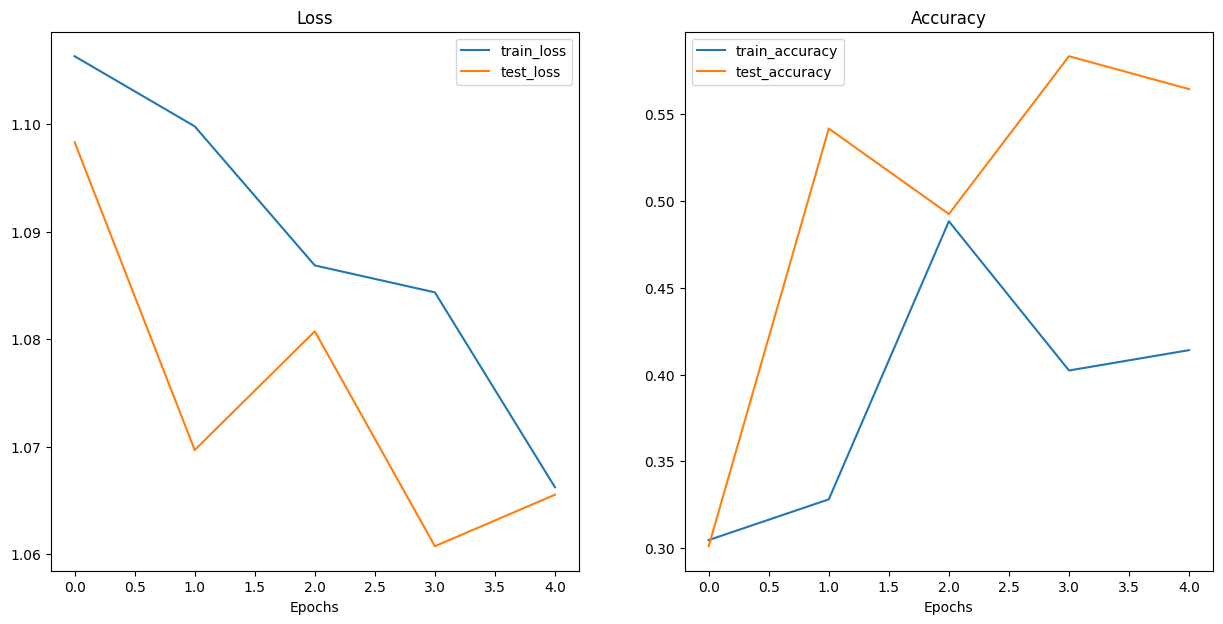

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [ ]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

### `TrivialAugmentWide` 是什麼？

`TrivialAugmentWide` 是 `torchvision.transforms` 模組中一個強大的資料增強（Data Augmentation）策略，它旨在幫助模型在訓練時看到更多樣化的資料，從而提高模型的泛化能力。

**核心思想：**

`TrivialAugmentWide` 的設計靈感來自於 `AutoAugment` 和 `RandAugment` 等自動化資料增強方法。這些方法的核心是從一個預定義的轉換操作池中，隨機選擇並應用一系列的圖像轉換。與手動微調增強策略相比，自動化方法通常能找到更有效的增強組合，並且減少了人工參與的需要。

**主要特點：**

1.  **操作池 (Operation Pool)**：`TrivialAugmentWide` 包含一個豐富的圖像轉換操作池，例如：
    *   `ShearX`, `ShearY` (剪切)
    *   `TranslateX`, `TranslateY` (平移)
    *   `Rotate` (旋轉)
    *   `Brightness`, `Color`, `Contrast`, `Sharpness` (色彩和銳利度調整)
    *   `Posterize`, `Solarize`, `AutoContrast`, `Equalize` (圖像像素操作)
    *   `RandomErasing` (隨機擦除)
    *   以及 `Identity` (不做任何改變) 等。

2.  **隨機選擇**：對於每一張輸入圖片，它會隨機選擇 **一個** 圖像轉換操作。例如，它可能會選擇 `Rotate`，也可能選擇 `Brightness`。

3.  **隨機強度 (Magnitude)**：當選定一個操作後，它會從該操作預定義的強度範圍中，隨機選擇一個增強強度來應用這個操作。這個強度是連續的，並且通常由 `num_magnitude_bins` 參數控制，該參數決定了強度範圍被劃分成多少個離散的 "bin"。

4.  **無學習參數**：與 `AutoAugment` 不同，`TrivialAugmentWide` 不需要額外的模型來學習增強策略，這使得它更容易使用和實現。

**`num_magnitude_bins` 參數：**

您在程式碼中看到的 `num_magnitude_bins=31` 表示每個增強操作的強度範圍會被切分為 31 個離散的等級。例如，如果 `Rotate` 操作的強度範圍是 `-30` 度到 `+30` 度，那麼這 31 個等級會均勻分佈在這個範圍內，`TrivialAugmentWide` 會從這 31 個等級中隨機挑選一個強度值來旋轉圖片。

**為什麼使用 `TrivialAugmentWide`？**

*   **提高泛化能力**：通過引入多樣化的圖像變換，模型能夠學會識別不同視角、光照、顏色變化的物體，使其在面對未見過的真實世界數據時表現更好。
*   **減少過擬合**：資料增強有效地擴大了訓練集，降低了模型記住訓練數據特定細節而無法推廣到新數據的風險。
*   **易於使用**：作為一個 `transforms.Compose` 的組件，它非常容易集成到現有的 PyTorch 資料處理流程中。

總之，`TrivialAugmentWide` 是一種高效且易於實施的資料增強策略，特別適合於視覺任務，能夠顯著提升模型的性能和魯棒性。


### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [ ]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1261 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0712 | Train acc: 0.4258 | Test loss: 1.1593 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1253 | Train acc: 0.3047 | Test loss: 1.1581 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0865 | Train acc: 0.4258 | Test loss: 1.1555 | Test acc: 0.3333
Total training time for model_1: 5.659 seconds


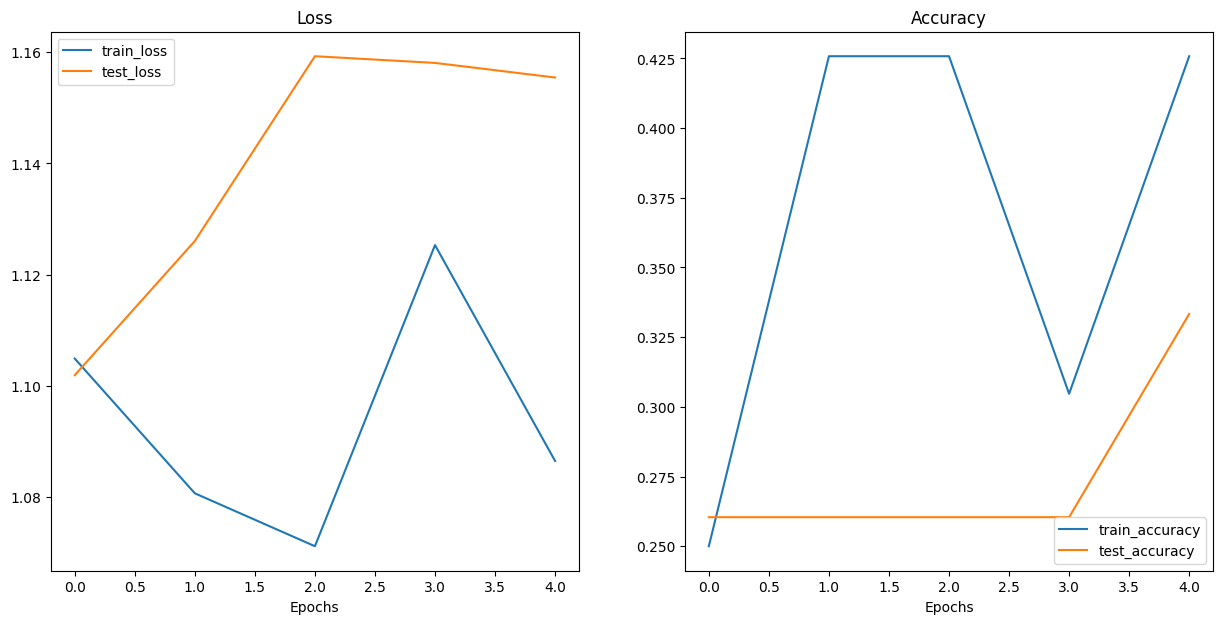

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/


In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.098321  0.301136
1    1.099798   0.328125   1.069688  0.541667
2    1.086860   0.488281   1.080731  0.492424
3    1.084354   0.402344   1.060743  0.583333
4    1.066225   0.414062   1.065535  0.564394

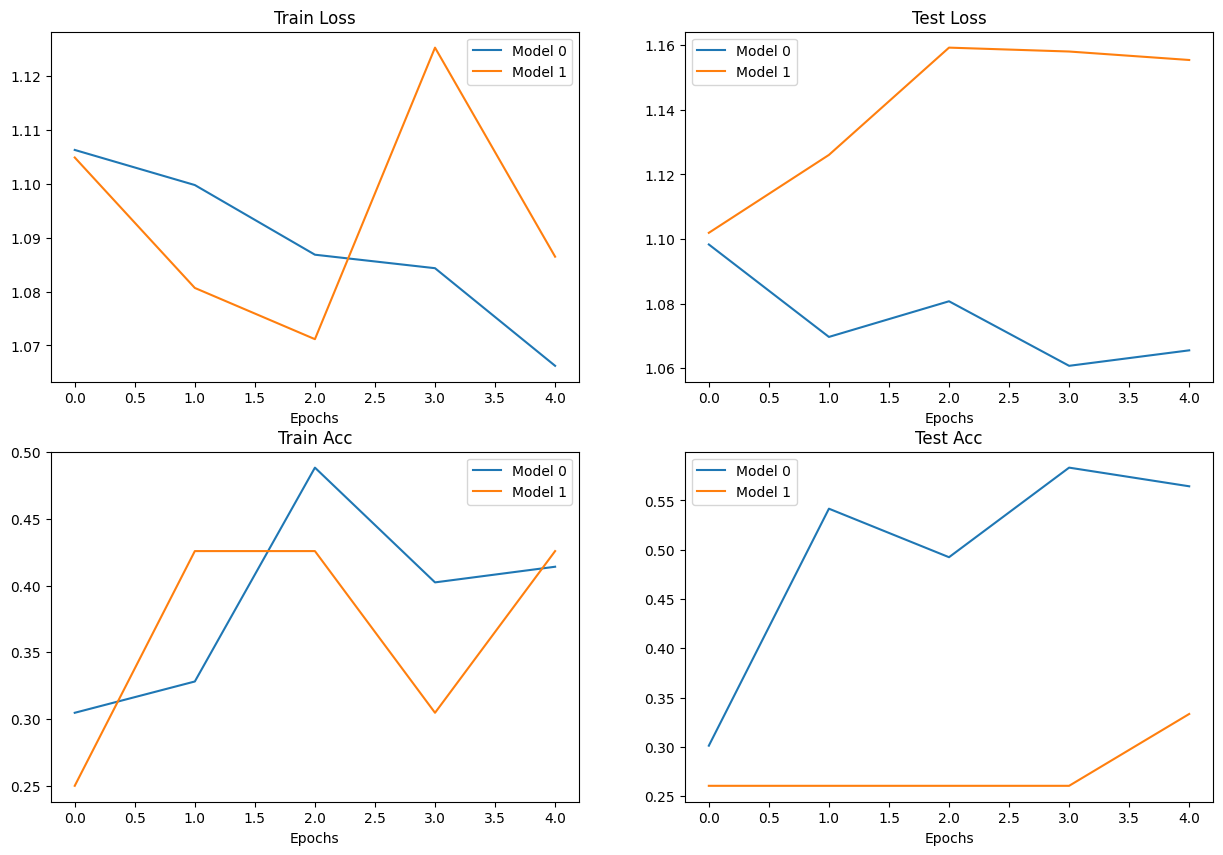

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [ ]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

`torchvision.io.read_image(...)`：這是 `torchvision `庫提供的一個函數，用於從檔案系統中讀取圖像。它會執行以下操作：

* 打開指定路徑的圖像檔案。
* 將圖像的像素資料讀取出來。
* 將這些像素資料轉換成一個 PyTorch 張量。這個張量的資料類型通常是 `torch.uint8` (無符號 8 位元整數)，代表每個像素通道的值範圍是 0 到 255。
* 張量的維度順序通常會是 `[C, H, W]`，也就是 [顏色通道數, 高度, 寬度]。對於 RGB 圖像，通道數為 3。



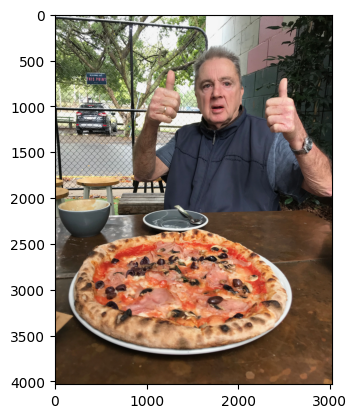

In [ ]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

資料型別不匹配：您的 `custom_image_uint8` 是 `torch.uint8 `型別 (無符號 8 位元整數)，它的像素值範圍通常是 0 到 255。而 PyTorch 模型（特別是卷積層的權重和偏差）通常使用 `torch.float32` (浮點數) 型別來進行計算

預處理步驟缺失：在將圖片送入模型之前，它需要經過與訓練資料相同的預處理步驟，這通常包括：

* 轉換為浮點型別：將像素值從 uint8 轉換為 float32。
* 正規化：將像素值從 0-255 範圍縮放到 0-1 範圍。
* 調整尺寸：將圖片調整到模型輸入層預期的尺寸 (例如 64x64)。
* 通道順序調整：確保通道順序是 [C, H, W] (通道、高、寬)

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image

tensor([[[154., 173., 181.,  ...,  21.,  18.,  14.],
         [146., 165., 181.,  ...,  21.,  18.,  15.],
         [124., 146., 172.,  ...,  18.,  17.,  15.],
         ...,
         [ 72.,  59.,  45.,  ..., 152., 150., 148.],
         [ 64.,  55.,  41.,  ..., 150., 147., 144.],
         [ 64.,  60.,  46.,  ..., 149., 146., 143.]],

        [[171., 190., 193.,  ...,  22.,  19.,  15.],
         [163., 182., 193.,  ...,  22.,  19.,  16.],
         [141., 163., 184.,  ...,  19.,  18.,  16.],
         ...,
         [ 55.,  42.,  28.,  ..., 107., 104., 103.],
         [ 47.,  38.,  24.,  ..., 108., 104., 102.],
         [ 47.,  43.,  29.,  ..., 107., 104., 101.]],

        [[119., 138., 147.,  ...,  17.,  14.,  10.],
         [111., 130., 145.,  ...,  17.,  14.,  11.],
         [ 87., 111., 136.,  ...,  14.,  13.,  11.],
         ...,
         [ 35.,  22.,   8.,  ...,  52.,  52.,  48.],
         [ 27.,  18.,   4.,  ...,  50.,  49.,  44.],
         [ 27.,  23.,   9.,  ...,  49.,  46.,  43.]]]

model吃的圖像為0~1之間的數值

In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.0
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
custom_image.shape

torch.Size([3, 4032, 3024])

將圖片調整到模型輸入層預期的尺寸 (例如 64x64)

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(64, 64))
])

# Transfrom target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


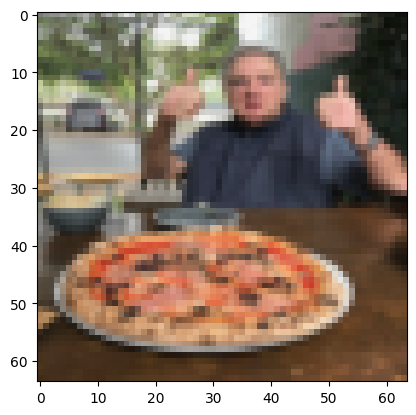

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [ ]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
# This should this work? (added a batch size...)
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0783,  0.0378, -0.2069]])

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3687, 0.3541, 0.2772]])

In [ ]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [ ]:
class_names[custom_image_pred_label]

'pizza'

class_names 是一個標準的 Python 列表（['pizza', 'steak', 'sushi']）。當您嘗試使用 class_names[custom_image_pred_label] 進行索引時，Python 列表的索引操作器 [] 預期接收一個標準的 Python 整數，而不是 PyTorch 張量（即使該張量只包含一個整數）。如果 custom_image_pred_label 仍在 GPU 上，Python 無法直接使用它作為索引，會導致錯誤。

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

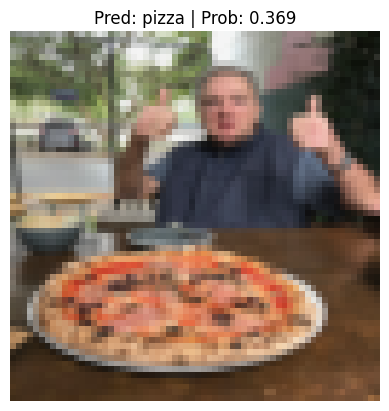

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## Exercises

For all exercises and extra-curriculum, see here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#exercises